In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

The following function checks for the xlsx (Excel) files in the data folder. Each spreadsheet should have a CM, EM and QM sheet with the same structure. Each sheet is then stored as a pandas dataframe with the name of the file followed by the sheet name, e.g. ChatGPT 5 responses_CM is the pandas dataframe with the Classical mechanics solutions stored in it. Each dataframe is then stored in a dictionary

In [8]:
def load_excel_sheets(data_dir='data'):
    # Find the Excel file in the data directory
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"The directory '{data_dir}' does not exist.")

    files = [f for f in os.listdir(data_dir) if f.endswith(".xlsx")]
    if not files:
        raise FileNotFoundError(f"No Excel file found in the '{data_dir}' directory.")

    dataframes = {}
    
    for file_name in files:
        file_path = os.path.join(data_dir, file_name)
        # Load the Excel file
        xls = pd.ExcelFile(file_path)
        print(f"Loaded Excel file: {file_path}")
        
        # Get filename without extension for the key
        file_base_name = os.path.splitext(file_name)[0]

        for sheet_name in xls.sheet_names:
            df = pd.read_excel(xls, sheet_name=sheet_name)
            # Clean column names by stripping whitespace
            df.columns = df.columns.str.strip()
            
            # Create unique key: filename_sheetname
            key = f"{file_base_name}_{sheet_name}"
            dataframes[key] = df
            print(f"  Loaded sheet: {sheet_name} as key: {key}")
    
    return dataframes

# Load all sheets into a dictionary of DataFrames
dfs = load_excel_sheets()

# Example: Display the keys
print("\nLoaded dataframe keys:", list(dfs.keys()))

Loaded Excel file: data\ChatGPT 4o diagram.xlsx
  Loaded sheet: CM as key: ChatGPT 4o diagram_CM
  Loaded sheet: EM as key: ChatGPT 4o diagram_EM
  Loaded sheet: QM as key: ChatGPT 4o diagram_QM
Loaded Excel file: data\ChatGPT 4o text.xlsx
  Loaded sheet: CM as key: ChatGPT 4o text_CM
  Loaded sheet: EM as key: ChatGPT 4o text_EM
  Loaded sheet: QM as key: ChatGPT 4o text_QM
Loaded Excel file: data\ChatGPT 5.1 diagram.xlsx
  Loaded sheet: CM as key: ChatGPT 5.1 diagram_CM
  Loaded sheet: EM as key: ChatGPT 5.1 diagram_EM
  Loaded sheet: QM as key: ChatGPT 5.1 diagram_QM
Loaded Excel file: data\ChatGPT 5.1 text.xlsx
  Loaded sheet: CM as key: ChatGPT 5.1 text_CM
  Loaded sheet: EM as key: ChatGPT 5.1 text_EM
  Loaded sheet: QM as key: ChatGPT 5.1 text_QM
Loaded Excel file: data\Gemini 2.5 diagram.xlsx
  Loaded sheet: CM as key: Gemini 2.5 diagram_CM
  Loaded sheet: EM as key: Gemini 2.5 diagram_EM
  Loaded sheet: QM as key: Gemini 2.5 diagram_QM
Loaded Excel file: data\Gemini 2.5 text.x

In [9]:
# Calculate the mean solution, standard deviation, and mean percentage mark for each dataframe
for key, df in dfs.items():
    # Identify the solution columns (assuming 'Solution 1', 'Solution 2', 'Solution 3')
    # We use a case-insensitive check to be robust
    solution_cols = [col for col in df.columns if col.lower() in ['solution 1', 'solution 2', 'solution 3']]
    
    if len(solution_cols) == 3:
        df['mean solution'] = df[solution_cols].mean(axis=1)
        df['std solution'] = df[solution_cols].std(axis=1)
        print(f"Added 'mean solution' and 'std solution' to {key}")
        
        # Calculate mean percentage mark
        # Check for 'Available marks' column (case-insensitive)
        available_marks_col = next((col for col in df.columns if col.lower() == 'available marks'), None)
        
        if available_marks_col:
            df['mean percentage mark'] = (df['mean solution'] / df[available_marks_col]) * 100
            print(f"Added 'mean percentage mark' to {key}")
        else:
            print(f"Skipped 'mean percentage mark' for {key}: 'Available marks' column not found")
            
    else:
        print(f"Skipped {key}: Expected 3 solution columns, found {len(solution_cols)} ({solution_cols})")

# Verify the result with the first dataframe
if dfs:
    first_key = list(dfs.keys())[0]
    print(f"\nFirst 5 rows of {first_key}:")
    display(dfs[first_key].head())

Added 'mean solution' and 'std solution' to ChatGPT 4o diagram_CM
Added 'mean percentage mark' to ChatGPT 4o diagram_CM
Added 'mean solution' and 'std solution' to ChatGPT 4o diagram_EM
Added 'mean percentage mark' to ChatGPT 4o diagram_EM
Added 'mean solution' and 'std solution' to ChatGPT 4o diagram_QM
Added 'mean percentage mark' to ChatGPT 4o diagram_QM
Added 'mean solution' and 'std solution' to ChatGPT 4o text_CM
Added 'mean percentage mark' to ChatGPT 4o text_CM
Added 'mean solution' and 'std solution' to ChatGPT 4o text_EM
Added 'mean percentage mark' to ChatGPT 4o text_EM
Added 'mean solution' and 'std solution' to ChatGPT 4o text_QM
Added 'mean percentage mark' to ChatGPT 4o text_QM
Added 'mean solution' and 'std solution' to ChatGPT 5.1 diagram_CM
Added 'mean percentage mark' to ChatGPT 5.1 diagram_CM
Added 'mean solution' and 'std solution' to ChatGPT 5.1 diagram_EM
Added 'mean percentage mark' to ChatGPT 5.1 diagram_EM
Added 'mean solution' and 'std solution' to ChatGPT 5.

,Question Number,Available Marks,Solution 1,Solution 2,Solution 3,mean solution,std solution,mean percentage mark
0,1,5,4,5,3,4.000000,1.000000,80.000000
1,2,6,6,1,1,2.666667,2.886751,44.444444
2,3,9,9,9,9,9.000000,0.000000,100.000000
3,4,10,10,10,10,10.000000,0.000000,100.000000
4,5,10,8,5,7,6.666667,1.527525,66.666667


In [10]:
def split_dataframes_by_type(dfs):
    diagrams_dfs = {}
    text_dfs = {}
    
    for key, df in dfs.items():
        # Check if 'diagram' is in the key (case-insensitive) to categorize
        if 'text' in key.lower():
            text_dfs[key] = df
        else:
            diagrams_dfs[key] = df
            
    return diagrams_dfs, text_dfs

# Split the dataframes
diagrams_dfs, text_dfs = split_dataframes_by_type(dfs)

print(f"Diagrams DataFrames: {list(diagrams_dfs.keys())}")
print(f"Text DataFrames: {list(text_dfs.keys())}")

Diagrams DataFrames: ['ChatGPT 4o diagram_CM', 'ChatGPT 4o diagram_EM', 'ChatGPT 4o diagram_QM', 'ChatGPT 5.1 diagram_CM', 'ChatGPT 5.1 diagram_EM', 'ChatGPT 5.1 diagram_QM', 'Gemini 2.5 diagram_CM', 'Gemini 2.5 diagram_EM', 'Gemini 2.5 diagram_QM', 'Gemini 3 diagram_CM', 'Gemini 3 diagram_EM', 'Gemini 3 diagram_QM', 'Handwritten Graded Data_EM', 'Handwritten Graded Data_QM', 'Handwritten Graded Data_CM']
Text DataFrames: ['ChatGPT 4o text_CM', 'ChatGPT 4o text_EM', 'ChatGPT 4o text_QM', 'ChatGPT 5.1 text_CM', 'ChatGPT 5.1 text_EM', 'ChatGPT 5.1 text_QM', 'Gemini 2.5 text_CM', 'Gemini 2.5 text_EM', 'Gemini 2.5 text_QM', 'Gemini 3 text_CM', 'Gemini 3 text_EM', 'Gemini 3 text_QM']


In [11]:
def calculate_sheet_stats(dfs):
    sheet_stats = {}
    for key, df in dfs.items():
        stats = {}
        
        # Check for 'Available marks' column (case-insensitive)
        available_marks_col = next((col for col in df.columns if col.lower() == 'available marks'), None)
        
        # Calculate mean percentage mark using Total Score / Total Available
        # This avoids skewing by questions with few marks (e.g. 1/1 = 100%)
        if available_marks_col and 'mean solution' in df.columns:
            # Ensure numeric types
            df['mean solution'] = pd.to_numeric(df['mean solution'], errors='coerce')
            df[available_marks_col] = pd.to_numeric(df[available_marks_col], errors='coerce')
            
            # Filter valid rows
            valid_mask = (df[available_marks_col] > 0) & (df['mean solution'].notna())
            valid_rows = df[valid_mask]
            
            total_solution = valid_rows['mean solution'].sum()
            total_available = valid_rows[available_marks_col].sum()
            
            if total_available > 0:
                stats['mean_percentage'] = (total_solution / total_available) * 100
            else:
                stats['mean_percentage'] = 0
        elif 'mean percentage mark' in df.columns:
            stats['mean_percentage'] = df['mean percentage mark'].mean()
        else:
            print(f"Warning: 'mean percentage mark' column not found in {key}")
            stats['mean_percentage'] = None
            
        # Calculate mean of 'std solution'
        if 'std solution' in df.columns:
            stats['mean_std'] = df['std solution'].mean()
        else:
            print(f"Warning: 'std solution' column not found in {key}")
            stats['mean_std'] = None
            
        sheet_stats[key] = stats
    return sheet_stats

# Calculate stats for all sheets
sheet_stats = calculate_sheet_stats(dfs)

# print("\nStatistics per Sheet:")
# for key, val in sheet_stats.items():
#     mean_pct = val['mean_percentage']
#     mean_std = val['mean_std']
    
#     pct_str = f"{mean_pct:.2f}%" if mean_pct is not None else "N/A"
#     std_str = f"{mean_std:.2f}" if mean_std is not None else "N/A"
    
#     print(f"{key}: Mean Percentage = {pct_str}, Mean Std Dev = {std_str}")

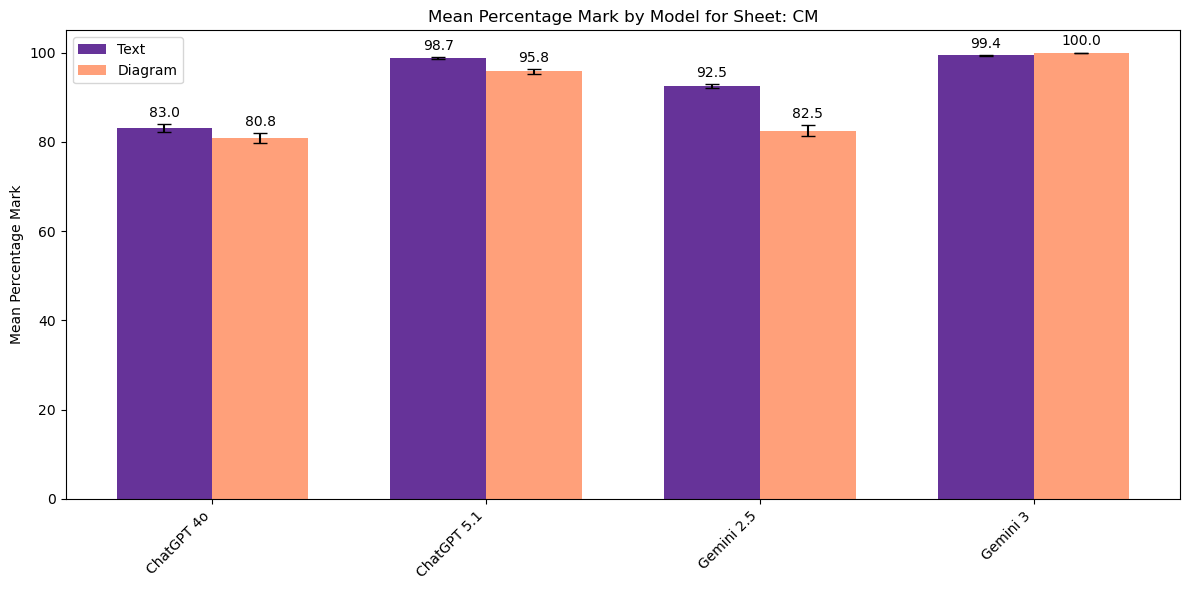

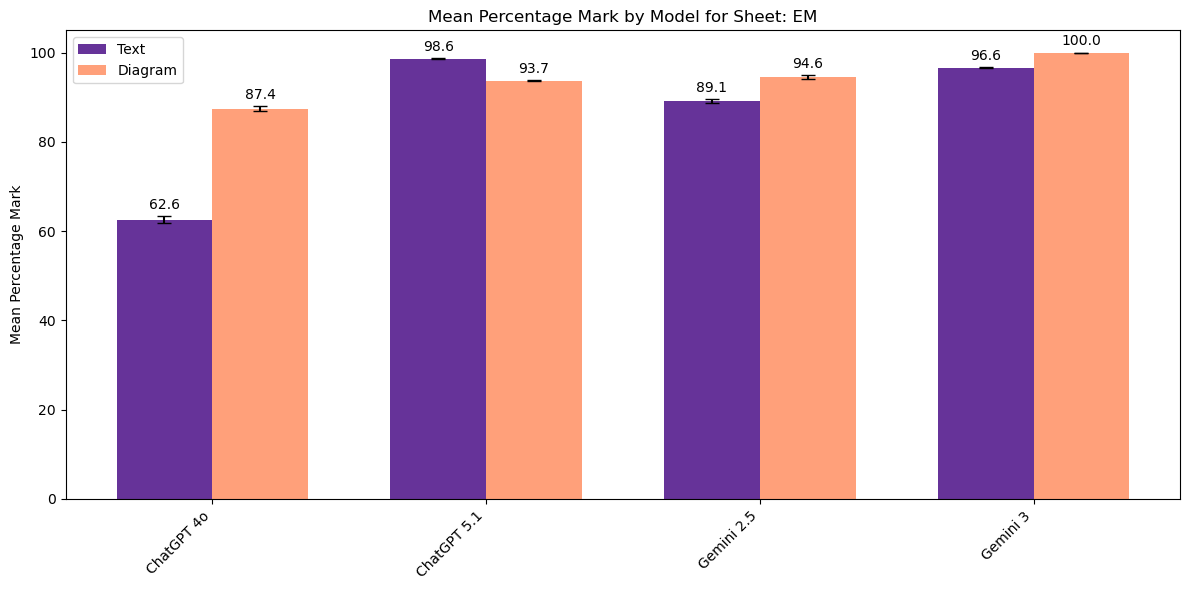

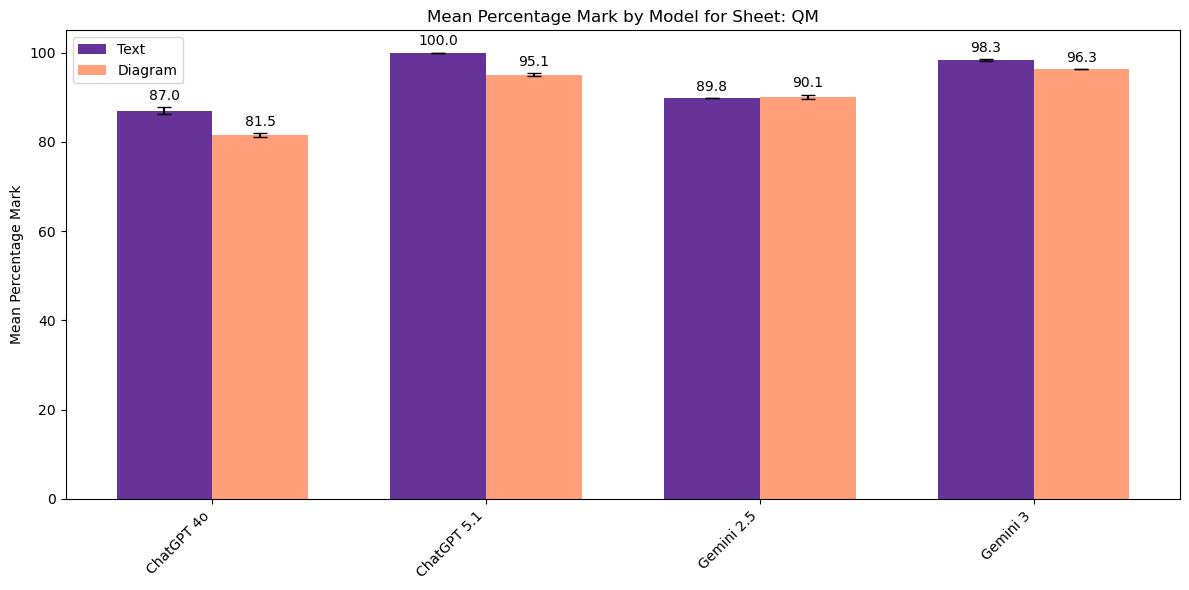

In [12]:
def plot_sheet_comparisons(diagrams_stats, text_stats):
    import matplotlib.pyplot as plt
    import numpy as np
    import re

    # Group data by Sheet Name, then by Model Name
    # Structure: { 'Sheet Name': { 'Model Name': {'Diagram': (mean, std), 'Text': (mean, std)} } }
    sheets_data = {}
    
    # Helper to process stats dictionary
    def process_stats(stats_dict, type_label):
        for key, stats in stats_dict.items():
            if stats['mean_percentage'] is None:
                continue
                
            # Split key to get filename and sheetname
            try:
                file_base, sheet_name = key.rsplit('_', 1)
            except ValueError:
                print(f"Skipping key with unexpected format: {key}")
                continue
            
            # Normalize model name
            # Remove 'diagram' and 'text' (case insensitive) and trim whitespace
            model_name = re.sub(r'\s*text\s*', '', file_base, flags=re.IGNORECASE)
            model_name = re.sub(r'\s*diagram\s*', '', model_name, flags=re.IGNORECASE).strip()
            
            # Also handle potential extra spaces or variations if needed
            model_name = model_name.strip()

            if sheet_name not in sheets_data:
                sheets_data[sheet_name] = {}
            
            if model_name not in sheets_data[sheet_name]:
                sheets_data[sheet_name][model_name] = {}
            
            sheets_data[sheet_name][model_name][type_label] = stats

    # Process both dictionaries
    process_stats(diagrams_stats, 'Diagram')
    process_stats(text_stats, 'Text')
        
    # Plot for each Sheet (CM, EM, QM)
    for sheet_name, models in sheets_data.items():
        # Prepare data for plotting
        model_names = sorted(list(models.keys()))
        
        means_diagram = []
        stds_diagram = []
        means_text = []
        stds_text = []
        
        for model in model_names:
            # Get Diagram stats
            d_stats = models[model].get('Diagram')
            if d_stats:
                means_diagram.append(d_stats['mean_percentage'])
                stds_diagram.append(d_stats['mean_std'])
            else:
                means_diagram.append(0)
                stds_diagram.append(0)
                
            # Get Non-Diagram stats
            nd_stats = models[model].get('Text')
            if nd_stats:
                means_text.append(nd_stats['mean_percentage'])
                stds_text.append(nd_stats['mean_std'])
            else:
                means_text.append(0)
                stds_text.append(0)
        
        # Plotting
        x = np.arange(len(model_names))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot Text bars
        rects1 = ax.bar(x - width/2, means_text, width, yerr=stds_text, label='Text', capsize=5, color='rebeccapurple')
        
        # Plot Diagram bars
        rects2 = ax.bar(x + width/2, means_diagram, width, yerr=stds_diagram, label='Diagram', capsize=5, color='lightsalmon')
        
        ax.set_ylabel('Mean Percentage Mark')
        ax.set_title(f'Mean Percentage Mark by Model for Sheet: {sheet_name}')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.legend()
        
        # Add labels
        ax.bar_label(rects1, padding=3, fmt='%.1f', labels=[f'{v:.1f}' if v > 0 else '' for v in means_text])
        ax.bar_label(rects2, padding=3, fmt='%.1f', labels=[f'{v:.1f}' if v > 0 else '' for v in means_diagram])
        
        plt.tight_layout()
        plt.show()

# Calculate stats for separated dataframes
diagrams_stats = calculate_sheet_stats(diagrams_dfs)
text_stats = calculate_sheet_stats(text_dfs)

# Plot the comparisons using the separated stats
plot_sheet_comparisons(diagrams_stats, text_stats)

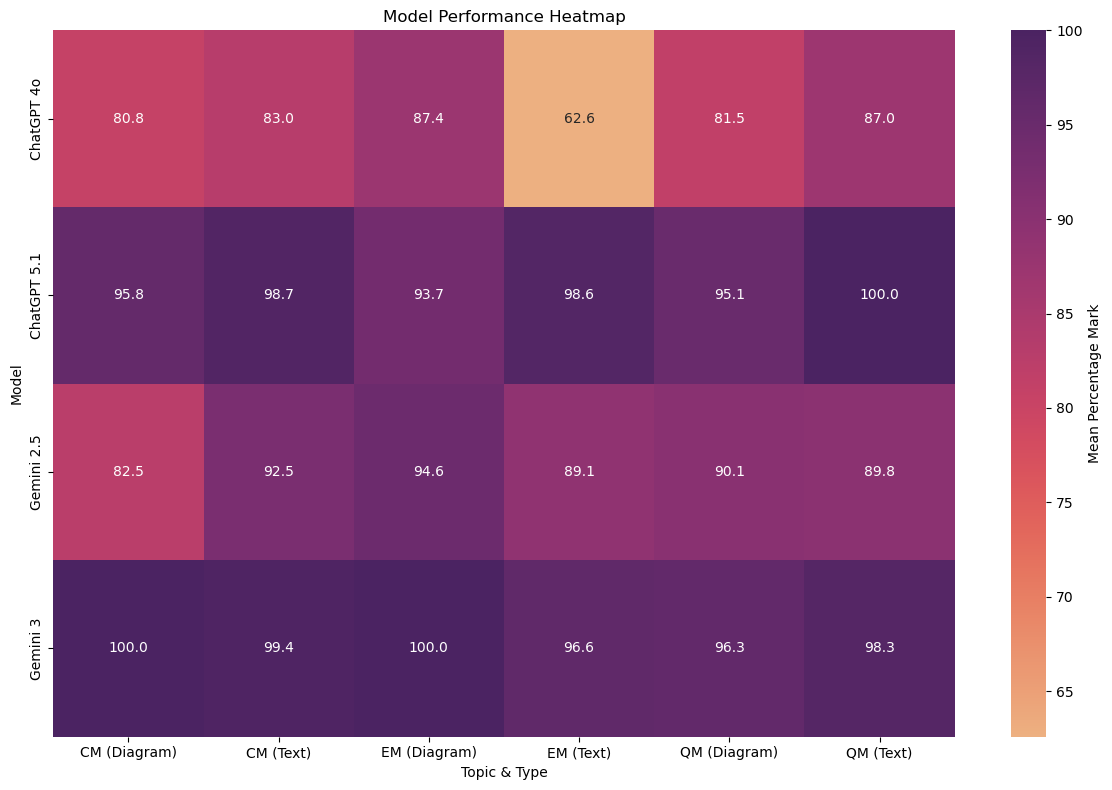

In [13]:
def plot_performance_heatmap(diagrams_stats, text_stats):
    

    # Prepare data for heatmap
    # Rows: Model Names
    # Columns: Sheet Name + Type (e.g., "CM (Diagram)", "CM (Non-Diagram)")
    
    data = []
    
    # Helper to process stats dictionary
    def process_stats(stats_dict, type_label):
        for key, stats in stats_dict.items():
            if stats['mean_percentage'] is None:
                continue
                
            # Split key to get filename and sheetname
            try:
                file_base, sheet_name = key.rsplit('_', 1)
            except ValueError:
                continue
            
            # Normalize model name
            model_name = re.sub(r'\s*text\s*', '', file_base, flags=re.IGNORECASE)
            model_name = re.sub(r'\s*diagram\s*', '', model_name, flags=re.IGNORECASE).strip()
            model_name = model_name.strip()
            
            column_name = f"{sheet_name} ({type_label})"
            
            data.append({
                'Model': model_name,
                'Category': column_name,
                'Score': stats['mean_percentage']
            })

    process_stats(diagrams_stats, 'Diagram')
    process_stats(text_stats, 'Text')
    
    if not data:
        print("No data available for heatmap.")
        return

    # Create DataFrame
    df_heatmap = pd.DataFrame(data)
    
    # Pivot table for heatmap format
    heatmap_data = df_heatmap.pivot_table(index='Model', columns='Category', values='Score')
    
    # Sort columns to keep Diagram/Non-Diagram pairs together if possible, or just alphabetically
    # Custom sort could be applied here if needed
    heatmap_data = heatmap_data.sort_index(axis=1)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="flare", cbar_kws={'label': 'Mean Percentage Mark'})
    plt.title('Model Performance Heatmap')
    plt.ylabel('Model')
    plt.xlabel('Topic & Type')
    plt.tight_layout()
    plt.show()

# Plot the heatmap
plot_performance_heatmap(diagrams_stats, text_stats)

In [14]:
file_path = "data/Handwritten Graded Data.xlsx"

# Columns expected per sheet
perfect_cols = [
    "GPT 5.1 - Perfect",
    "Deepseek - Perfect",
    "Gemini 2.5 Flash Perfect",
    "Gemini 3 Pro Perfect",
    "GPT 4o Perfect",
]
imperfect_cols = [
    "GPT 5.1 - Imperfect",
    "Deepseek - Imperfect",
    "Gemini 2.5 Flash Imperfect",
    "Gemini 3 Pro Imperfect",
    "GPT 4o Imperfect",
]
required_base = {
    "available marks": "Available Marks",
    "human graded imperfect": "Human Graded Imperfect",
    "question number": "Question Number",
}

xls = pd.ExcelFile(file_path)
all_dfs = []

for sheet_name in xls.sheet_names:  # EMT, QM, CM
    df = pd.read_excel(xls, sheet_name=sheet_name)

    # Normalize and standardize column names (strip + lowercase) then map back to canonical
    col_map = {col: col.strip().lower() for col in df.columns}
    df.columns = [col.strip() for col in df.columns]
    lower_to_original = {col.strip().lower(): col.strip() for col in df.columns}

    # Ensure required columns exist
    missing = [orig for key, orig in required_base.items() if key not in lower_to_original]
    if missing:
        raise KeyError(f"Sheet '{sheet_name}' is missing required columns: {missing}")

    # Reindex the required columns to canonical names for consistency
    rename_dict = {lower_to_original[key]: required_base[key] for key in required_base}
    df = df.rename(columns=rename_dict)

    # Convert numeric columns
    numeric_cols = perfect_cols + imperfect_cols + ["Available Marks", "Human Graded Imperfect"]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        else:
            # Helpful debug for missing numeric columns
            print(f"Warning: Column '{col}' not found in sheet '{sheet_name}'")

    # ----- PERFECT -----
    perfect_long = df.melt(
        id_vars=["Question Number", "Available Marks"],
        value_vars=[c for c in perfect_cols if c in df.columns],
        var_name="LLM",
        value_name="LLM_Grade",
    )
    perfect_long["Quality"] = "Perfect"
    perfect_long["Human_Grade"] = perfect_long["Available Marks"]

    # ----- IMPERFECT -----
    imperfect_long = df.melt(
        id_vars=["Question Number", "Available Marks", "Human Graded Imperfect"],
        value_vars=[c for c in imperfect_cols if c in df.columns],
        var_name="LLM",
        value_name="LLM_Grade",
    )
    imperfect_long["Quality"] = "Imperfect"
    imperfect_long["Human_Grade"] = imperfect_long["Human Graded Imperfect"]

    # Combine for this module
    combined = pd.concat([perfect_long, imperfect_long], ignore_index=True)
    combined["Module"] = sheet_name
    all_dfs.append(combined)

# Combine all modules
long_df = pd.concat(all_dfs, ignore_index=True)

# Compute accuracy metrics
long_df["Signed_Error"] = long_df["LLM_Grade"] - long_df["Human_Grade"]
long_df["Absolute_Error"] = long_df["Signed_Error"].abs()

print("DATA READY:")
print(long_df.head())

DATA READY:
   Question Number  Available Marks                LLM  LLM_Grade  Quality  \
0              2.0              5.0  GPT 5.1 - Perfect        5.0  Perfect   
1              4.0             11.0  GPT 5.1 - Perfect       11.0  Perfect   
2              7.0              6.0  GPT 5.1 - Perfect        6.0  Perfect   
3              9.0             15.0  GPT 5.1 - Perfect       14.0  Perfect   
4             10.0              7.0  GPT 5.1 - Perfect        5.0  Perfect   

   Human_Grade  Human Graded Imperfect Module  Signed_Error  Absolute_Error  
0          5.0                     NaN     EM           0.0             0.0  
1         11.0                     NaN     EM           0.0             0.0  
2          6.0                     NaN     EM           0.0             0.0  
3         15.0                     NaN     EM          -1.0             1.0  
4          7.0                     NaN     EM          -2.0             2.0  


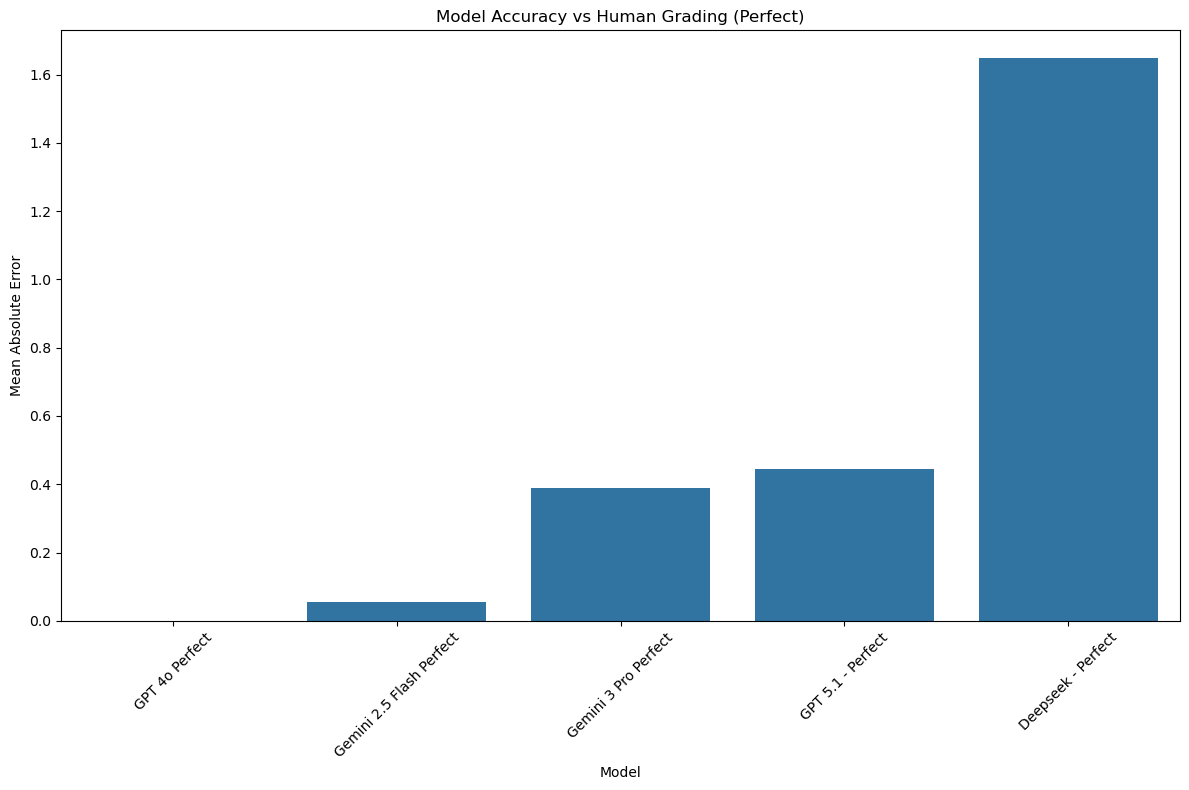

In [15]:
# Mean Absolute Error – Perfect only
if "Quality" not in long_df.columns:
    raise KeyError("long_df is missing the 'Quality' column. Ensure earlier cells ran successfully.")

mae_perfect = (
    long_df[long_df["Quality"] == "Perfect"]
    .groupby("LLM")["Absolute_Error"]
    .mean()
    .sort_values()
)

plt.figure(figsize=(12, 8))
sns.barplot(x=mae_perfect.index, y=mae_perfect.values)
plt.xticks(rotation=45)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Model")
plt.title("Model Accuracy vs Human Grading (Perfect)")
plt.tight_layout()
plt.show()

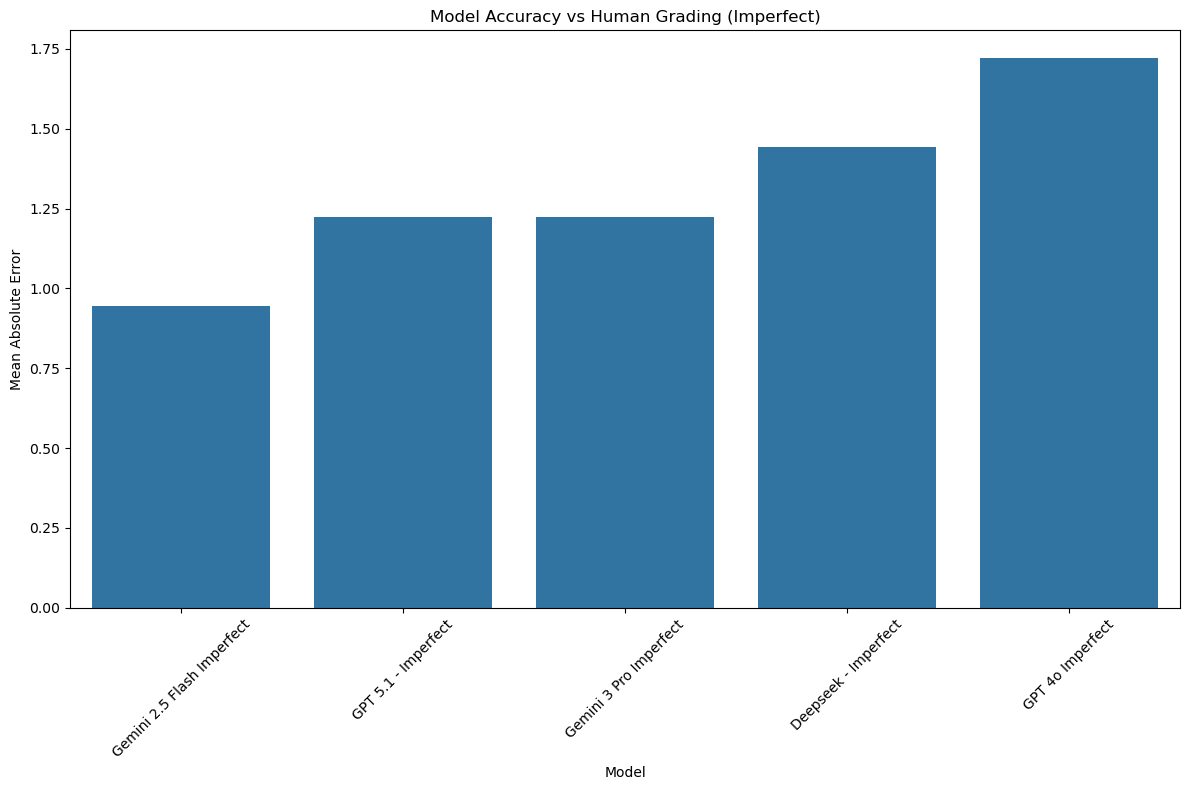

In [16]:
# Mean Absolute Error – Imperfect only
mae_imperfect = (
    long_df[long_df["Quality"] == "Imperfect"]
    .groupby("LLM")["Absolute_Error"]
    .mean()
    .sort_values()
)

plt.figure(figsize=(12, 8))
sns.barplot(x=mae_imperfect.index, y=mae_imperfect.values)
plt.xticks(rotation=45)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Model")
plt.title("Model Accuracy vs Human Grading (Imperfect)")
plt.tight_layout()
plt.show()

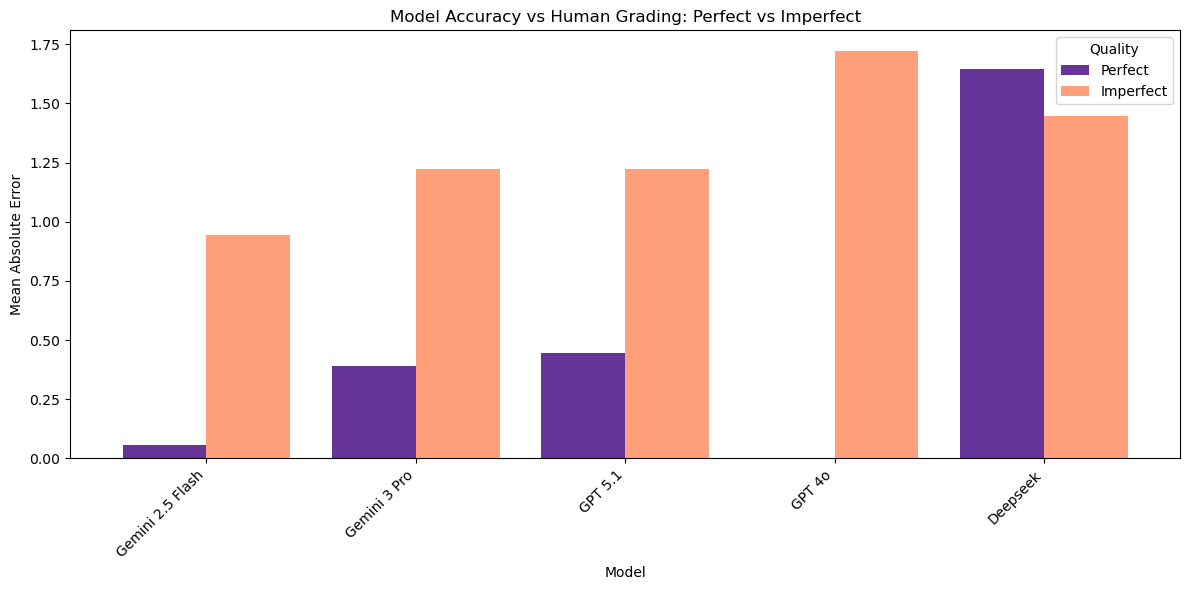

In [17]:
import re

# Create a clean LLM name column for alignment
# Removes " - Perfect", " Perfect", " - Imperfect", " Imperfect" from the end
long_df["LLM_Base"] = long_df["LLM"].apply(lambda x: re.sub(r"[\s-]*(Perfect|Imperfect)$", "", x, flags=re.IGNORECASE))

# Calculate MAE grouped by Base LLM and Quality
mae_grouped = (
    long_df.groupby(["LLM_Base", "Quality"])["Absolute_Error"]
    .mean()
    .unstack()  # Pivot Quality to columns
)

# Ensure specific column order for consistent coloring
mae_grouped = mae_grouped[["Perfect", "Imperfect"]]

# Sort by average error
mae_grouped["Average"] = mae_grouped.mean(axis=1)
mae_grouped = mae_grouped.sort_values("Average")
mae_grouped = mae_grouped.drop(columns=["Average"])

# Plot grouped bar chart
ax = mae_grouped.plot(kind="bar", figsize=(12, 6), width=0.8, color=["rebeccapurple", "lightsalmon"])
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error")
plt.title("Model Accuracy vs Human Grading: Perfect vs Imperfect")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Quality")
plt.tight_layout()
plt.show()

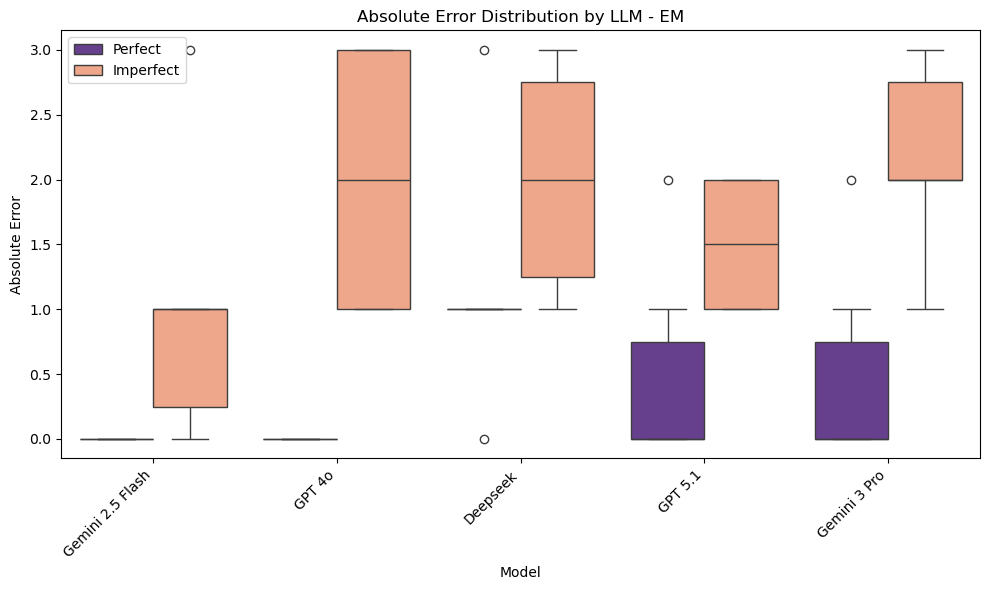

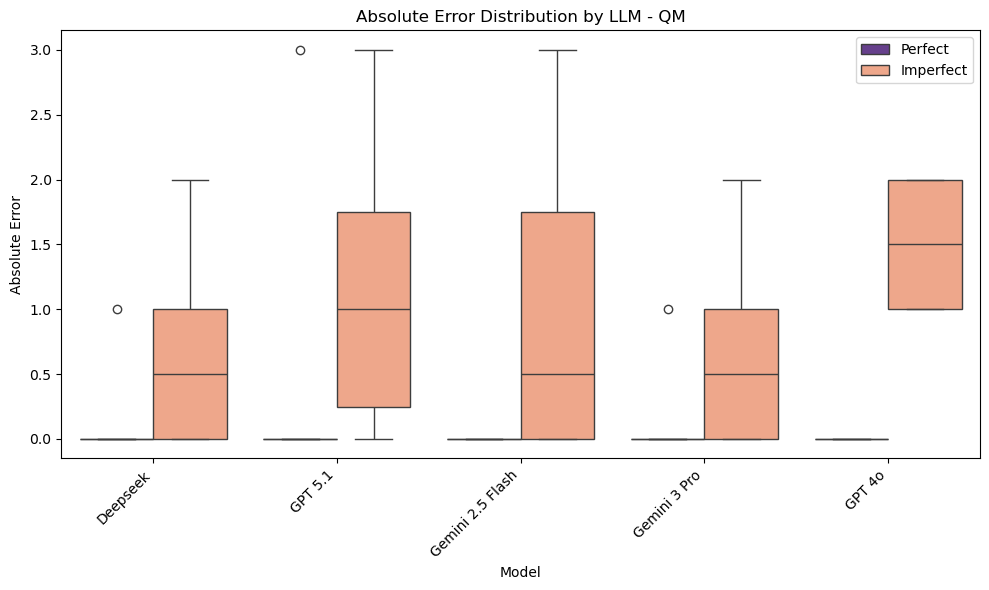

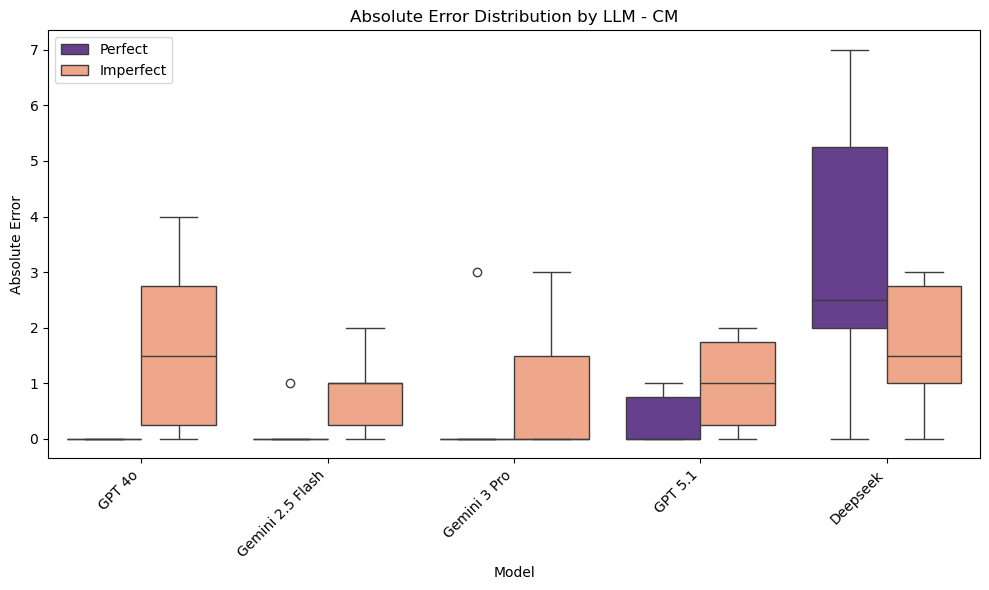

In [18]:
# Box plots of Absolute Error by LLM for each Sheet (Module)

# Ensure LLM_Base exists (in case previous cell wasn't run)
if "LLM_Base" not in long_df.columns:
    import re
    long_df["LLM_Base"] = long_df["LLM"].apply(lambda x: re.sub(r"[\s-]*(Perfect|Imperfect)$", "", x, flags=re.IGNORECASE))

modules = long_df["Module"].unique()

for module in modules:
    plt.figure(figsize=(10, 6))
    subset = long_df[long_df["Module"] == module]
    
    # Determine sort order based on median absolute error
    order = subset.groupby("LLM_Base")["Absolute_Error"].median().sort_values().index
    
    sns.boxplot(data=subset, x="LLM_Base", y="Absolute_Error", hue="Quality", order=order, palette=["rebeccapurple", "lightsalmon"])
    plt.title(f"Absolute Error Distribution by LLM - {module}")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Absolute Error")
    plt.xlabel("Model")
    plt.legend()
    plt.tight_layout()
    plt.show()

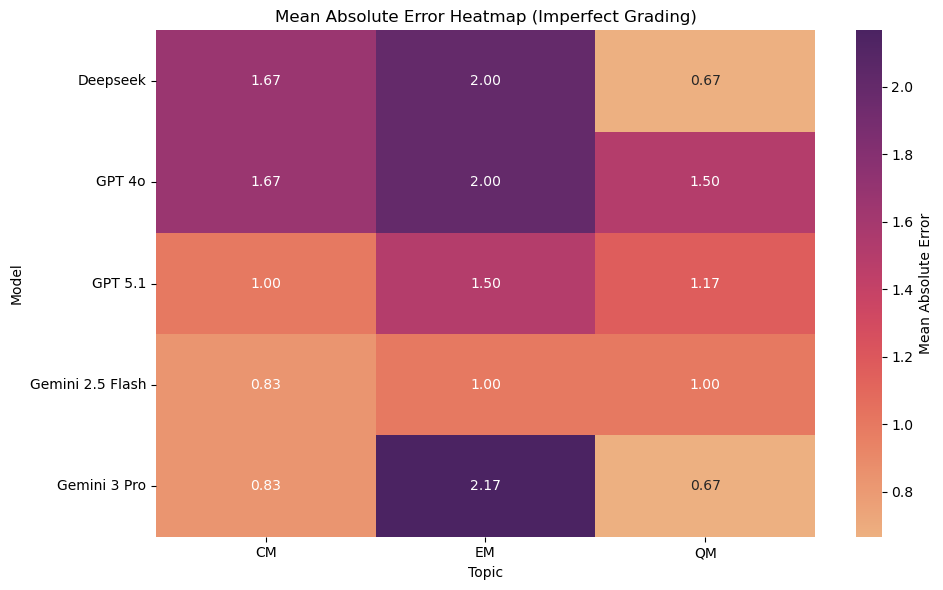

In [19]:
# Heatmap of Mean Absolute Error for Imperfect Grading by Sheet

# Filter for Imperfect quality
imperfect_df = long_df[long_df["Quality"] == "Imperfect"]

# Calculate Mean Absolute Error grouped by LLM and Module
heatmap_data = (
    imperfect_df.groupby(["LLM_Base", "Module"])["Absolute_Error"]
    .mean()
    .unstack()  # Pivot Module to columns
)

# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="flare", cbar_kws={'label': 'Mean Absolute Error'})
plt.title("Mean Absolute Error Heatmap (Imperfect Grading)")
plt.ylabel("Model")
plt.xlabel("Topic")
plt.tight_layout()
plt.show()

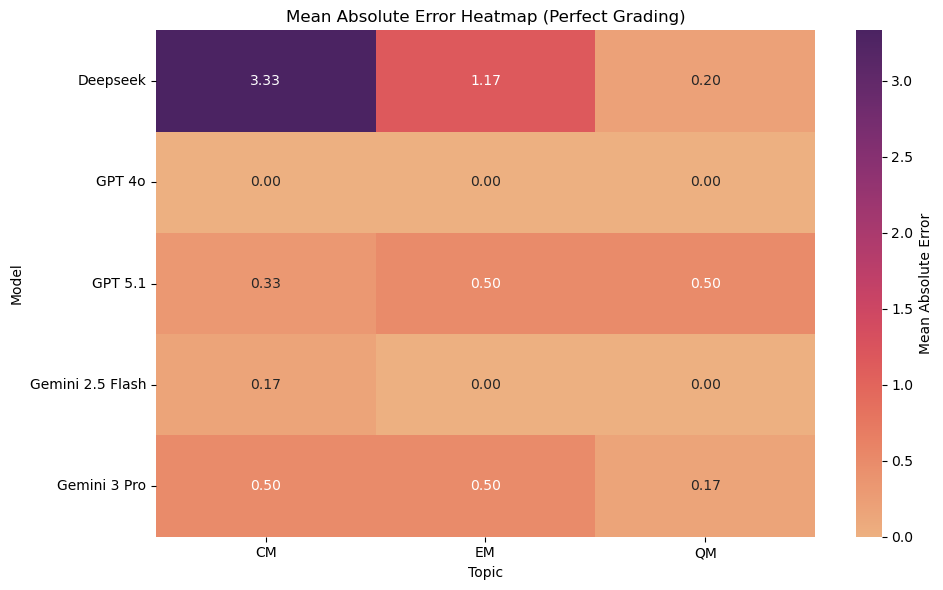

In [20]:
# Heatmap of Mean Absolute Error for perfect Grading by Sheet

# Filter for Perfect quality
perfect_df = long_df[long_df["Quality"] == "Perfect"]

# Calculate Mean Absolute Error grouped by LLM and Module
heatmap_data = (
    perfect_df.groupby(["LLM_Base", "Module"])["Absolute_Error"]
    .mean()
    .unstack()  # Pivot Module to columns
)

# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="flare", cbar_kws={'label': 'Mean Absolute Error'})
plt.title("Mean Absolute Error Heatmap (Perfect Grading)")
plt.ylabel("Model")
plt.xlabel("Topic")
plt.tight_layout()
plt.show()

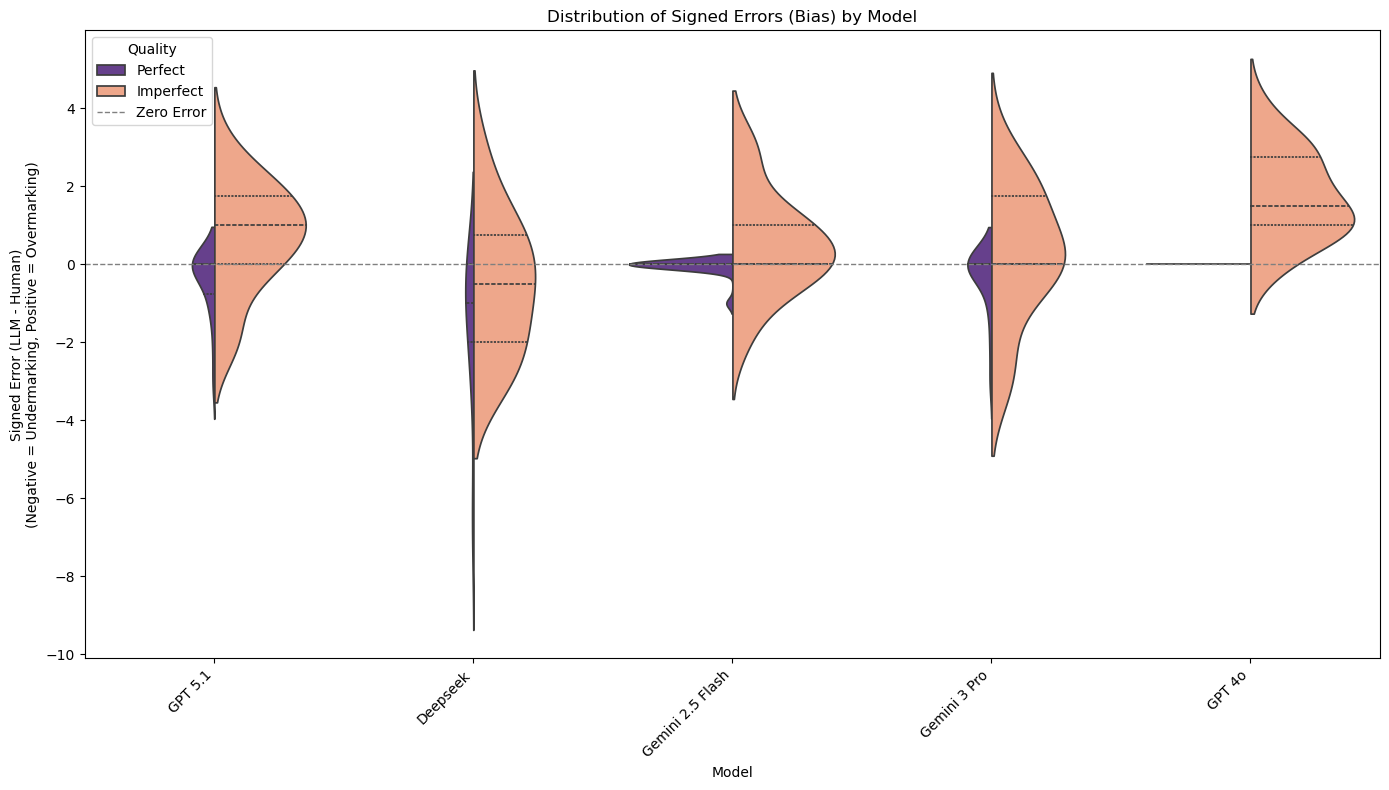

In [21]:
# 1. Violin Plot of Signed Errors (Bias Analysis)
# This shows the distribution of errors. 
# - Centered on 0 means unbiased.
# - Above 0 means the LLM tends to overgrade (lenient).
# - Below 0 means the LLM tends to undergrade (harsh).
# - The width shows the frequency of that error magnitude.

plt.figure(figsize=(14, 8))
sns.violinplot(
    data=long_df,
    x="LLM_Base",
    y="Signed_Error",
    hue="Quality",
    split=True,
    inner="quartile",
    palette={"Perfect": "rebeccapurple", "Imperfect": "lightsalmon"}
)
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label="Zero Error")
plt.title("Distribution of Signed Errors (Bias) by Model")
plt.ylabel("Signed Error (LLM - Human)\n(Negative = Undermarking, Positive = Overmarking)")
plt.xlabel("Model")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Quality")
plt.tight_layout()
plt.show()


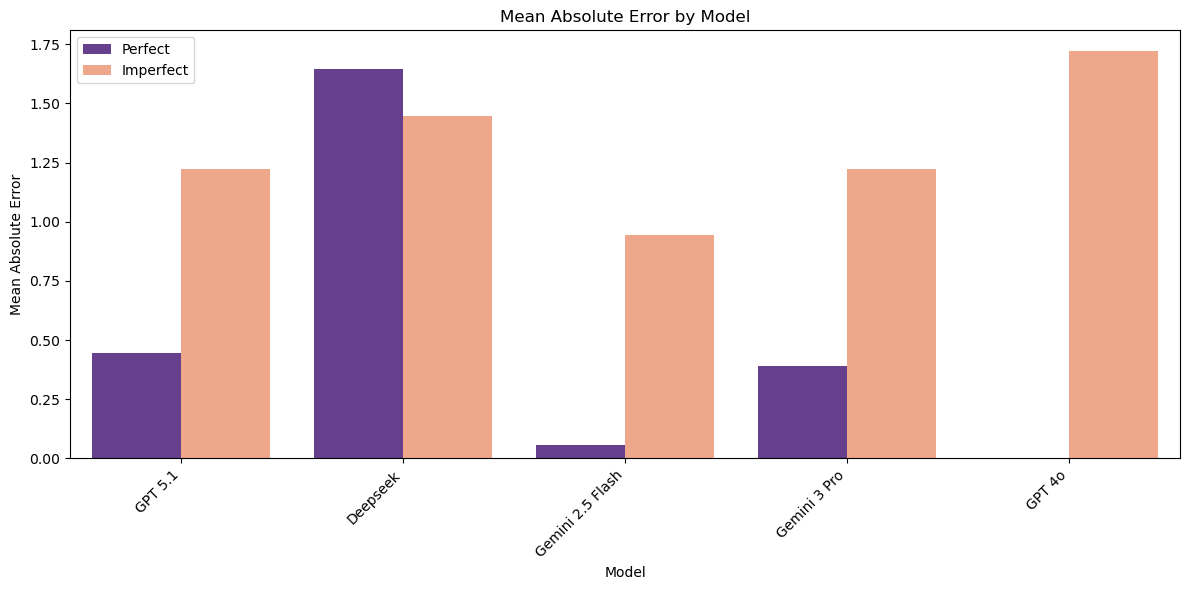

In [22]:

# 2. Bar Plot without Error Bars
# Plots the mean absolute error without confidence intervals.

plt.figure(figsize=(12, 6))
sns.barplot(
    data=long_df,
    x="LLM_Base",
    y="Absolute_Error",
    hue="Quality",
    palette={"Perfect": "rebeccapurple", "Imperfect": "lightsalmon"},
    errorbar=None,  # Removed error bars
)
plt.title("Mean Absolute Error by Model")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Model")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

The above graph is identical to a previous graph I was testing the colour palette between Seaborn and Matplotlib

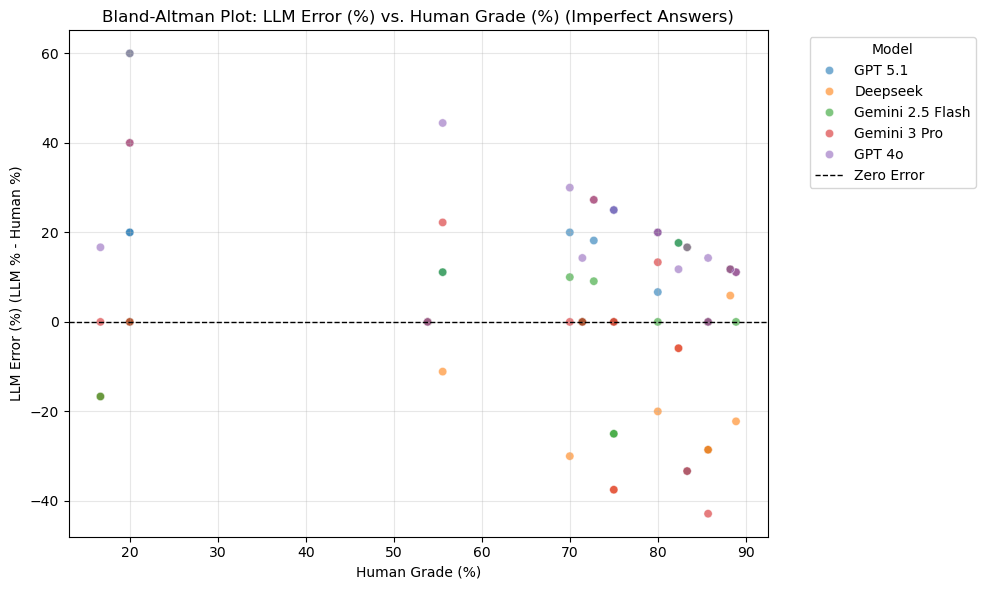

In [24]:
# Bland-Altman Plot: Human Grade (%) vs. LLM Error (%) (for Imperfect answers)

# Filter for relevant data
subset = long_df[long_df["Quality"] == "Imperfect"].copy()

# Ensure LLM_Base column exists if not already present
if "LLM_Base" not in subset.columns:
    subset["LLM_Base"] = subset["LLM"].apply(lambda x: re.sub(r"[\s-]*(Perfect|Imperfect)$", "", x, flags=re.IGNORECASE))

# Calculate percentages
subset["Human_Percentage"] = (subset["Human_Grade"] / subset["Available Marks"]) * 100
subset["Error_Percentage"] = (subset["Signed_Error"] / subset["Available Marks"]) * 100

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=subset,
    x="Human_Percentage",
    y="Error_Percentage",
    hue="LLM_Base",
    alpha=0.6,
    # distinct palette
    palette="tab10"
)

plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Error")
plt.title("Bland-Altman Plot: LLM Error (%) vs. Human Grade (%) (Imperfect Answers)")
plt.xlabel("Human Grade (%)")
plt.ylabel("LLM Error (%) (LLM % - Human %)")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

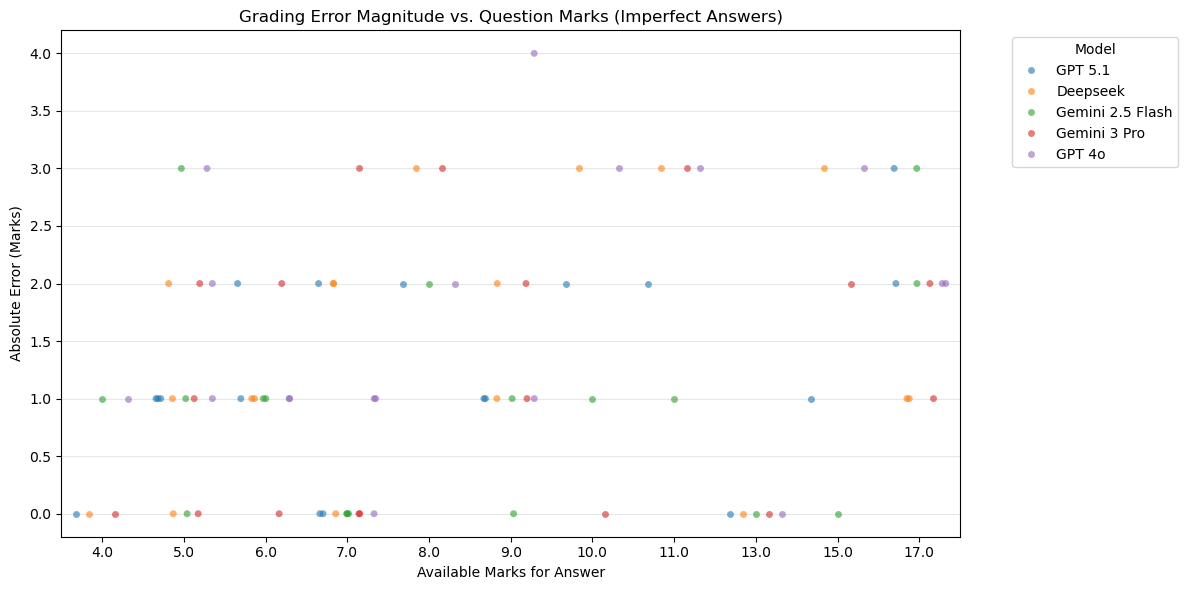

In [ ]:
# Impact of Question Value on Grading Error (Signed)
# X-axis: Available Marks (Question Size)
# Y-axis: Signed Error (Direction of Error in Marks)

subset = long_df[long_df["Quality"] == "Imperfect"].copy()
if "LLM_Base" not in subset.columns:
    subset["LLM_Base"] = subset["LLM"].apply(lambda x: re.sub(r"[\s-]*(Perfect|Imperfect)$", "", x, flags=re.IGNORECASE))

plt.figure(figsize=(12, 6))

# Using stripplot to handle discrete x-axis values (Available Marks) with jitter to show density
sns.stripplot(
    data=subset,
    x="Available Marks",
    y="Signed_Error",
    hue="LLM_Base",
    dodge=True,        # Separate models for each x value
    jitter=0.2,        # Add random noise to x position to avoid overlap
    alpha=0.6,
    palette="tab10"
)

plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Error")
plt.title("Grading Bias vs. Question Marks (Imperfect Answers)")
plt.xlabel("Available Marks for Answer")
plt.ylabel("Signed Error (Marks) (LLM - Human)")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()